### Predict if a mail is spam or not 

**Data Description:** 
    
Refer: https://archive.ics.uci.edu/ml/datasets/spambase for detailed data description

* Number of Observations: 4601 (1813 Spam = 39.4%)
* Number of Attributes: 58 (57 continuous, 1 nominal class label)

** Attributes **

* 48 continuous real [0,100] attributes of type word_freq_WORD = percentage of words in the e-mail that match WORD, i.e. 100 * (number of times the WORD appears in the e-mail) / total number of words in e-mail. A "word" in this case is any string of alphanumeric characters bounded by non-alphanumeric characters or end-of-string. 

* 6 continuous real [0,100] attributes of type char_freq_CHAR] = percentage of characters in the e-mail that match CHAR, i.e. 100 * (number of CHAR occurences) / total characters in e-mail 

* 1 continuous real [1,...] attribute of type capital_run_length_average  = average length of uninterrupted sequences of capital letters 

* 1 continuous integer [1,...] attribute of type capital_run_length_longest = length of longest uninterrupted sequence of capital letters 

* 1 continuous integer [1,...] attribute of type capital_run_length_total  = sum of length of uninterrupted sequences of capital letters = total number of capital letters in the e-mail 

* 1 nominal {0,1} class attribute of type spam = denotes whether the e-mail was considered spam (1) or not (0), i.e. unsolicited commercial e-mail. 

### Naive Bayes Classifier

Under the iid assumption, the optimum classifier is:

\begin{equation}
f(x) = arg\ \underset{y \in Y}{max}\ P \left(Y = y\ |\ X = x\right)
\end{equation}

Applying Bayes Rule we split the posterior into class prior and class conditional distribution of X

\begin{equation}
f(x) = arg\ \underset{y \in Y}{max}\ P \left(Y = y\right) \times P\left(X = x\ |\ Y = y\right)
\end{equation}

Naive Bayes classifier treats the dimensions of X as conditionally independent given y, hence we get:

\begin{equation}
f(x) = arg\ \underset{y \in Y}{max}\ P \left(Y = y\right) \times \prod^{d}_{j=1} p_j \left(x[j]|Y=y \right)
\end{equation}

** Data used for this implementation is available at [Github Link](https://github.com/anujk3/ml_datasets/tree/master/ml-nb)**

### Implementation

In [2]:
## Imports and Loading Data

import numpy as np
import matplotlib.pyplot as plt
import operator
#import scipy
from scipy.special import expit
%matplotlib inline


X_train = np.genfromtxt('hw2-data/X_train.csv', delimiter=',')
y_train = np.genfromtxt('hw2-data/y_train.csv')

X_test = np.genfromtxt('hw2-data/X_test.csv', delimiter=',')
y_test = np.genfromtxt('hw2-data/y_test.csv')

In [3]:
def get_prior(y_train):
    train_inputs = y_train
    unique_labels, counts = np.unique(train_inputs, return_counts=True)
    output = {}
    for i, label in enumerate(unique_labels):
        output[int(label)] = float(counts[i])/len(train_inputs)
    return output        

In [4]:
def bernoulli_MLE(feature_col, y_train):
    possible_labels = np.unique(y_train)
    output = []
    for label in possible_labels:
        if int(label) == 0:
            output.append(float(np.sum(feature_col) - np.sum(feature_col*y_train)) / (len(y_train) - np.sum(y_train)))
        else:
            output.append(float(np.sum(feature_col*y_train)) / np.sum(y_train))
    return output

In [5]:
def pareto_MLE(feature_col, y_train):
    possible_labels = np.unique(y_train)
    output = []
    for label in possible_labels:
        if int(label) == 0:
            output.append(float(len(y_train) - np.sum(y_train)) / np.sum((1-y_train)*np.log(feature_col)))
        else:
            output.append(float(np.sum(y_train)) / np.sum(np.log(feature_col)*y_train))
    return output

In [6]:
def get_MLE_features(X_train, y_train):
    MLE_vector = []
    for feature_col in xrange(0, X_train.shape[1]):
        if feature_col < 54:
            MLE_vector.append(bernoulli_MLE(X_train[:, feature_col], y_train))
        else:
            MLE_vector.append(pareto_MLE(X_train[:, feature_col], y_train))
    return MLE_vector

In [7]:
def getBernoulliDist(MLE_vector, feature_val, label):
    return np.power(MLE_vector[label], feature_val) * np.power((1 - MLE_vector[label]), (1 - feature_val))

In [8]:
def getParetoDist(MLE_vector, feature_val, label):
    return MLE_vector[label] * np.power(feature_val, -(MLE_vector[label] + 1))

In [9]:
def BayesClassifier(X_train, y_train, X_test, y_test):
    MLE_vector = get_MLE_features(X_train, y_train)
    priors = get_prior(y_train)
    possible_labels = np.unique(y_train)
    predicted_outputs = []
    for i, x_test_vector in enumerate(X_test):
        output_vector = []
        for label in possible_labels:
            label = int(label)
            output = 1
            for i, feature_val in enumerate(x_test_vector):
                if i < 54:
                    output = output * getBernoulliDist(MLE_vector[i], feature_val, label)
                else:
                    output = output * getParetoDist(MLE_vector[i], feature_val, label)
            output = output * priors[label]
            output_vector.append(output)
        predicted_outputs.append(output_vector)
    return predicted_outputs

In [10]:
def show_confusion_matrix(tp, fp, tn, fn ,class_labels=['0','1']):

    fig = plt.figure(figsize=(6, 4))
    ax  = fig.add_subplot(111)

    # Draw the grid boxes
    ax.set_xlim(-0.5,1.5)
    ax.set_ylim(1.5,-0.5)
    
    ax.plot([-0.5,1.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,1.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,1.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,1.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.5,1.16)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1])
    ax.yaxis.set_label_coords(-0.09,0.45)


#     Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,'True Negative: %d'%(tn),va='center',ha='center',bbox=dict(fc='w',boxstyle='round,pad=1'))
    ax.text(0,1,'False Negative: %d'%fn,va='center',ha='center',bbox=dict(fc='w',boxstyle='round,pad=1'))
    ax.text(1,0,'False Positive: %d'%fp,va='center',ha='center',bbox=dict(fc='w',boxstyle='round,pad=1'))
    ax.text(1,1,'True Positive: %d'%(tp),va='center',ha='center',bbox=dict(fc='w',boxstyle='round,pad=1'))
    
    ax.text(2, 0.5, r'Prediction Accuracy = (54 + 32)/93 = 0.9247 or 92.47%', fontsize=15)
    plt.tight_layout()
    plt.show()

In [11]:
def prediction_accuracy_Bayes(predicted_values, y_test):    
    predicted_classes = []
    for a, b in predicted_values:
        if a > b:
            predicted_classes.append(0)
        else:
            predicted_classes.append(1)
    total = 0
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for i in xrange(len(predicted_classes)):
        if predicted_classes[i] == y_test[i]:
            total += 1
        if (predicted_classes[i] == 0) and (y_test[i] == 0):
            tn += 1
        if (predicted_classes[i] == 0) and (y_test[i] == 1):
            fn += 1
        if (predicted_classes[i] == 1) and (y_test[i] == 0):
            fp += 1
        if (predicted_classes[i] == 1) and (y_test[i] == 1):
            tp += 1
    
    return float(total)/len(predicted_classes), tp, fp, tn, fn

In [12]:
predicted_values = BayesClassifier(X_train, y_train, X_test, y_test)

In [1]:
#predicted_values

In [50]:
accuracy, tp, fp, tn, fn = prediction_accuracy_Bayes(predicted_values, y_test)
#print accuracy
#print tp, fp, tn, fn

### Output Confusion Matrix

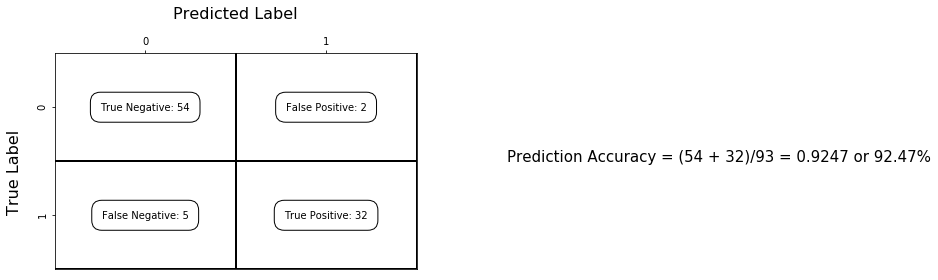

In [51]:
show_confusion_matrix(tp, fp, tn, fn)

---

## b) Stem Plot in Matplotlib

In [52]:
MLE_parameters = get_MLE_features(X_train, y_train)
bernoulli_MLE_parameters = MLE_parameters[0:54]
class_zero, class_one = zip(*bernoulli_MLE_parameters)

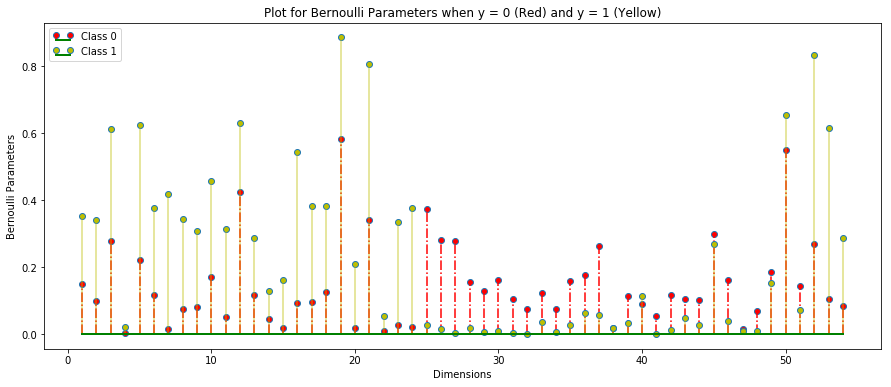

In [53]:
plt.close('all')
f, (ax1) = plt.subplots(1, 1, figsize=(15, 6))
markerline, stemlines, baseline = ax1.stem(range(1, 55), class_zero, '-.')
plt.setp(baseline, 'color', 'g', 'linewidth', 2)
plt.setp(markerline, 'markerfacecolor', 'r')
plt.setp(stemlines, 'color', 'r')
ax1.set_xlabel("Dimensions")
ax1.set_ylabel("Bernoulli Parameters")
markerline, stemlines, baseline = ax1.stem(range(1, 55), class_one, '-')
plt.setp(baseline, 'color', 'g', 'linewidth', 2)
plt.setp(markerline, 'markerfacecolor', 'y')
plt.setp(stemlines, 'color', 'y','alpha', 0.5)
plt.legend(["Class 0", "Class 1"], loc='best', numpoints=2)
plt.title("Plot for Bernoulli Parameters when y = 0 (Red) and y = 1 (Yellow)")
plt.show()

## Use the file spambase.names to make an observation about dimensions 16 and 52

** The dimension 16 is the word frequency for "Free". For Class 0, the MLE estimate is 0.0911 as compard to for Class 1, the MLE estimate is 0.545. So, we can say that for Class 0 (not a spam mail) the likelihood of seeing the word free is 0.091 as compared to Class 1 (spam mail) where it is 0.545.**

** The dimension 52 is the char frequency for "!". For Class 0, the MLE estimate is 0.269 as compard to for Class 1, the MLE estimate is 0.833. So, we can say that for Class 0 (not a spam mail) the likelihood of seeing the word free is 0.269 as compared to Class 1 (spam mail) where it is 0.833.**

### Since the Bernoulli parameters are just the average number of documents that have X = x ("free" or "!") when y = 1 (or 0), we can say that given a spam mail, there is a higher probability for the occurrence of "!" and "free" as compared to a non-spam mail.

---